In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/mlproj/test_tit.csv")
train = pd.read_csv("/content/drive/MyDrive/mlproj/train_tit.csv")

In [ ]:
test_answers = pd.read_csv('/content/drive/MyDrive/mlproj/gender_submission.csv')


#  Базовий EDA

In [ ]:
train.describe(include='all')

PassengerId    Survived      Pclass                     Name   Sex  \
count    891.000000  891.000000  891.000000                      891   891   
unique          NaN         NaN         NaN                      891     2   
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
freq            NaN         NaN         NaN                        1   577   
mean     446.000000    0.383838    2.308642                      NaN   NaN   
std      257.353842    0.486592    0.836071                      NaN   NaN   
min        1.000000    0.000000    1.000000                      NaN   NaN   
25%      223.500000    0.000000    2.000000                      NaN   NaN   
50%      446.000000    0.000000    3.000000                      NaN   NaN   
75%      668.500000    1.000000    3.000000                      NaN   NaN   
max      891.000000    1.000000    3.000000                      NaN   NaN   

               Age       SibSp       Parch  Ticket        Fare    Cabin  \
count   714.000000  891.000000  891.000000     891  891.000000      204   
unique         NaN         NaN         NaN     681         NaN      147   
top            NaN         NaN         NaN  347082         NaN  B96 B98   
freq           NaN         NaN         NaN       7         NaN        4   
mean     29.699118    0.523008    0.381594     NaN   32.204208      NaN   
std      14.526497    1.102743    0.806057     NaN   49.693429      NaN   
min       0.420000    0.000000    0.000000     NaN    0.000000      NaN   
25%      20.125000    0.000000    0.000000     NaN    7.910400      NaN   
50%      28.000000    0.000000    0.000000     NaN   14.454200      NaN   
75%      38.000000    1.000000    0.000000     NaN   31.000000      NaN   
max      80.000000    8.000000    6.000000     NaN  512.329200      NaN   

       Embarked  
count       889  
unique        3  
top           S  
freq        644  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

In [ ]:
profile = ProfileReport(train)

In [ ]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
pd.crosstab(train.Pclass, train.Survived, margins=True).style.background_gradient(cmap='coolwarm_r')

In [ ]:
train.groupby(['Survived','Sex'])['Survived'].count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Survived, dtype: int64

In [ ]:
pd.crosstab([train.Sex, train.Survived], train.Pclass, margins=True).style.background_gradient(cmap='inferno')

In [ ]:
sns.catplot(x='Survived', col='Embarked', kind='count', data=train);


Висновки, що вплинуть на валідацію моделі:

PassengerId, name, ticket, cabine (77.1% missing values) with high cardinality - вирішила виключити їх із аналізу, оскільки це унікальні значення, у яких складно знайти закономірності, тому вони не будуть корисними для навчання моделі. У випадку з cabine ще й складно відновити пропущені значення через малу кількість доступних даних.

Survived and sex - високо скорельовані, що означає, що одна із статей мала більше шансів, щоб вижити(Жінки мали більший шанс вижити, ніж чоловіки).
Важливу роль відігравав соціальний статус (оцінюємо за класом, у якому був пасажир). Пасажири з 3 Pclass мали найменші шанси вижити, особливо чоловіки.



Щоб забезпечити рівномірний розподіл цільової змінної (не вижили (61.6%) - вижили (38.4%)), збалансоване представлення класу в кожному наборі даних для валідації я обрала підхід  Stratified K fold Cross Validation.


In [ ]:
# fiil in missung value
train["Age"].fillna (train.Age.mean(), inplace = True)
test["Age"].fillna (test.Age.mean(), inplace = True)

train["Fare"].fillna (train.Fare.mean(), inplace = True)
test["Fare"].fillna (test.Fare.mean(), inplace = True)

train['Embarked'] = train['Embarked'].fillna('S')  # S - common value
test['Embarked'] = test['Embarked'].fillna('S')



In [ ]:
cat_vars = ['Sex', 'Pclass', 'Embarked']

In [ ]:
# перетворюємо категоріальні дані на числові
encoder = OneHotEncoder(handle_unknown='ignore')

In [ ]:
encoded_train = encoder.fit_transform(train[cat_vars])
encoded_test = encoder.transform(test[cat_vars])

In [ ]:
encoded_train = pd.DataFrame(encoded_train.toarray(), columns=encoder.get_feature_names_out(cat_vars))
encoded_test = pd.DataFrame(encoded_test.toarray(), columns=encoder.get_feature_names_out(cat_vars))


In [ ]:
train_encoded = pd.concat([train.drop(cat_vars, axis=1), encoded_train], axis=1)
test_encoded = pd.concat([test.drop(cat_vars, axis=1), encoded_test], axis=1)

In [ ]:
train_encoded = train_encoded.drop(['PassengerId', 'Cabin', 'Name', 'Ticket'], axis=1)
test_encoded = test_encoded.drop(['PassengerId', 'Cabin', 'Name', 'Ticket'], axis=1)

# Валідація

In [ ]:
X = train_encoded.drop(['Survived'], axis=1)
y = train_encoded['Survived']

In [ ]:
max_depths = range(1, 17)
max_features = range(1, 12)
min_samples_leafs = range(1, 17)

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
best_score = 0
best_params = {}

for depth in max_depths:
    for feature in max_features:
        for leaf in min_samples_leafs:
            print(f"Training model with max_depth={depth}, max_features={feature}, min_samples_leaf={leaf}")
            score = 0
            for train_index, val_index in skf.split(X, y):
                X_train, X_val = X.iloc[train_index].reset_index(drop=True), X.iloc[val_index].reset_index(drop=True)
                y_train, y_val = y[train_index], y[val_index]
                model = DecisionTreeClassifier(max_depth=depth, max_features=feature, min_samples_leaf=leaf)
                model.fit(X_train, y_train)
                score += model.score(X_val, y_val)
            avg_score = score/5
            print(f"Average validation accuracy: {avg_score}")
            if avg_score > best_score:
                best_score = avg_score
                best_params = {'max_depth': depth, 'max_features': feature, 'min_samples_leaf': leaf}

print(f"Best validation accuracy: {best_score}")
print(f"Best parameters: {best_params}")

Показано результат, скорочений до останніх рядків (5000).
Training model with max_depth=2, max_features=9, min_samples_leaf=14
Average validation accuracy: 0.7777540644027369
Training model with max_depth=2, max_features=9, min_samples_leaf=15
Average validation accuracy: 0.7755131504613646
Training model with max_depth=2, max_features=9, min_samples_leaf=16
Average validation accuracy: 0.7777728956123282
Training model with max_depth=2, max_features=10, min_samples_leaf=1
Average validation accuracy: 0.7777666185424644
Training model with max_depth=2, max_features=10, min_samples_leaf=2
Average validation accuracy: 0.7732659594501288
Training model with max_depth=2, max_features=10, min_samples_leaf=3
Average validation accuracy: 0.7766493001067103
Training model with max_depth=2, max_features=10, min_samples_leaf=4
Average validation accuracy: 0.7766367459669826
Training model with max_depth=2, max_features=10, min_samples_leaf=5
Average validation accuracy: 0.7788839369782187
Traini

# Візуалізація дерева рішень та інтерпретація моделі
(опишіть найважливіші особливості, чи є поділ логічним тощо)


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
model = DecisionTreeClassifier(max_depth = 11, max_features = 11, min_samples_leaf = 5)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, max_features=11, min_samples_leaf=5)

In [ ]:
dot_data = export_graphviz(model, out_file=None,
                           feature_names=X_train.columns,
                           class_names=['0', '1'],
                           filled=True, rounded=True,
                           special_characters=True)

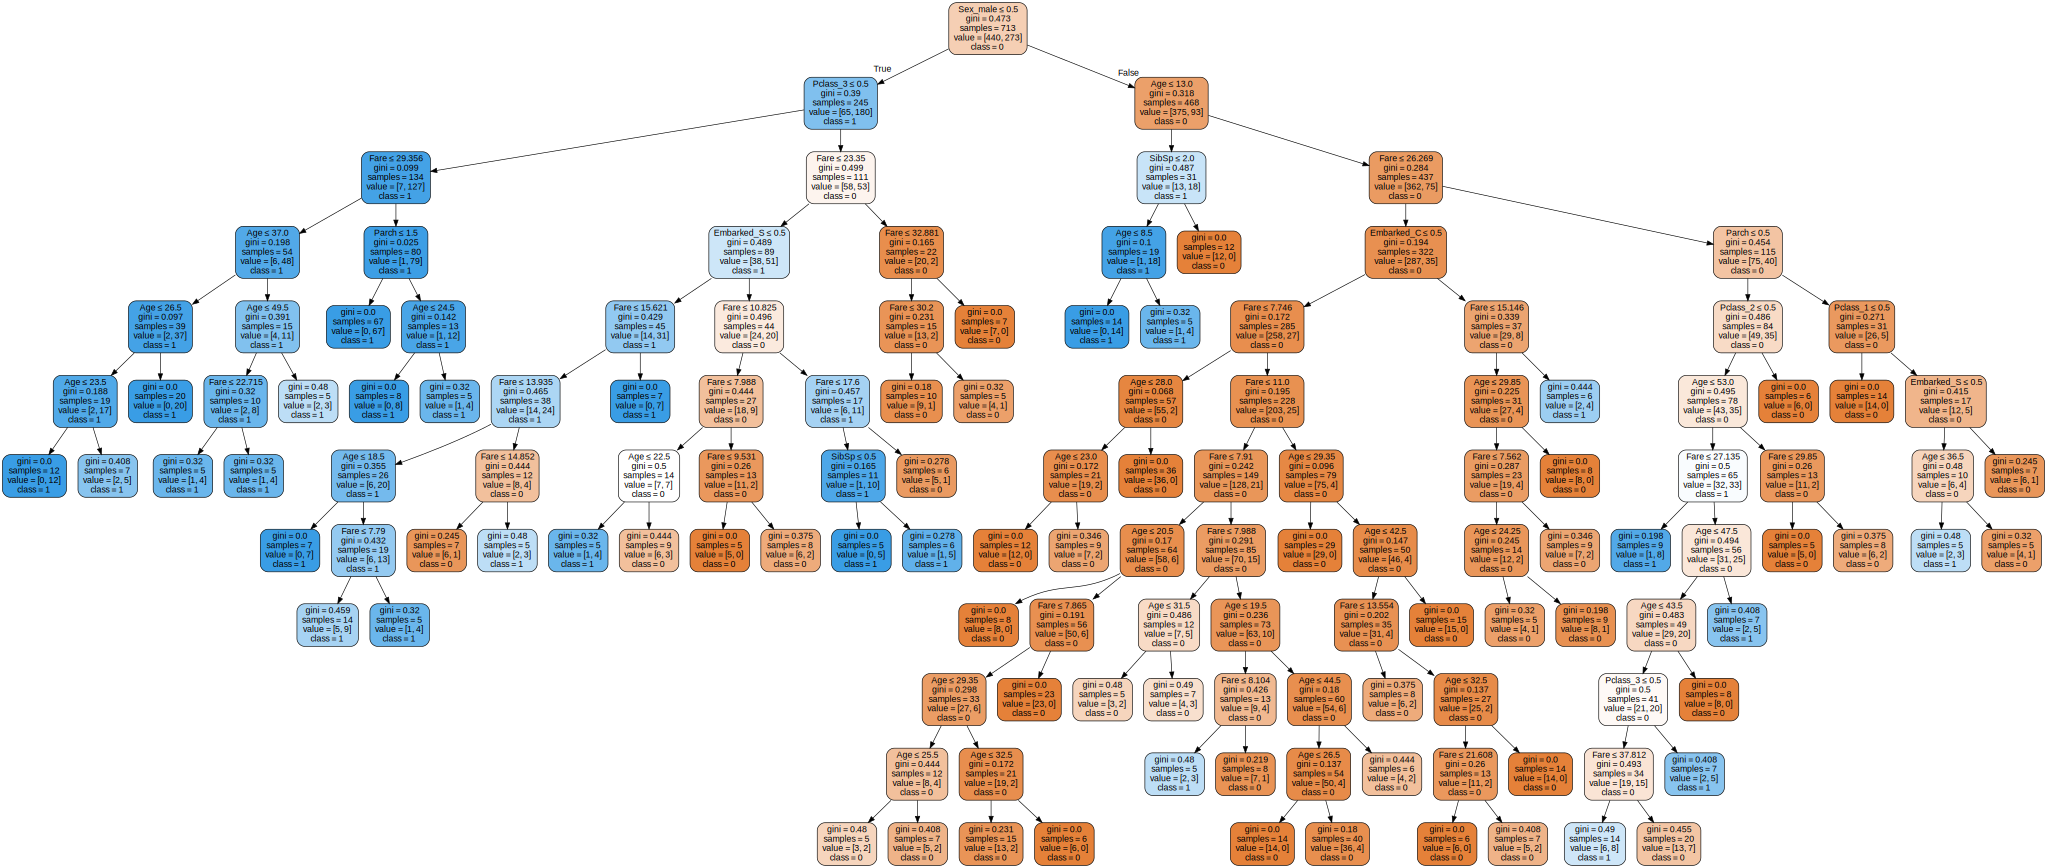

In [ ]:
graph = graphviz.Source(dot_data)
graph


Із візуалізації видно, що
1.   Дерево рішень робить висновки, зважаючи на Sex (ця метрика була високо скорельованою із нашою таргетованою змінною. базовий  EDA показав, що стать була одним із вирішальних факторів, що вплинули на показник вижив-не вижив), Pclass і Fare (припущення щодо впливу соціального статусу та рівня заможності підтвердилися в остаточній моделі), Age. Рідше зʼявляються SibSp, Parch, Embarked.
2.   Розподіл видається логічним



# Порівняння прогнозів - валідація і тест

---



In [ ]:
test_predictions = model.predict(test_encoded)

In [ ]:
accuracy = accuracy_score(test_answers['Survived'], test_predictions)
print("Accuracy on test dataset:", accuracy)
print(f"Best validation accuracy: {best_score}")

Accuracy on test dataset: 0.854066985645933
Best validation accuracy: 0.8383780051471973
